# Loop 12 Analysis: Understanding the Gap to Target

**Current Best**: 70.630478
**Target**: 68.919154
**Gap**: 1.711 points (2.48%)

This analysis will:
1. Analyze per-N score breakdown to find where improvements are possible
2. Compare our solutions to theoretical bounds
3. Identify which N values have the most room for improvement

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

getcontext().prec = 25
scale_factor = Decimal("1e15")

class ChristmasTree:
    def __init__(self, center_x="0", center_y="0", angle="0"):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w = Decimal("0.4")
        top_w = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal("0.0") * scale_factor, tip_y * scale_factor),
            (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x * scale_factor),
            yoff=float(self.center_y * scale_factor),
        )

def calculate_score(trees):
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / 1e15 for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    side = max(max_x - min_x, max_y - min_y)
    score = side ** 2 / len(trees)
    return score, side

def load_trees(n, df):
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        x = str(row["x"]).lstrip('s')
        y = str(row["y"]).lstrip('s')
        deg = str(row["deg"]).lstrip('s')
        trees.append(ChristmasTree(x, y, deg))
    return trees

print("Functions defined successfully")

Functions defined successfully


In [2]:
# Load current best solution
df = pd.read_csv('/home/code/exploration/datasets/saspav_best.csv')
print(f"Loaded {len(df)} rows")

# Calculate per-N scores
scores = []
for n in range(1, 201):
    trees = load_trees(n, df)
    score, side = calculate_score(trees)
    scores.append({'n': n, 'score': score, 'side': side})

scores_df = pd.DataFrame(scores)
print(f"\nTotal score: {scores_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {scores_df['score'].sum() - 68.919154:.6f}")

Loaded 20100 rows



Total score: 70.630478
Target: 68.919154
Gap: 1.711324


In [3]:
# Calculate theoretical lower bound
# For a single tree, the minimum bounding box side is approximately 0.813 (at 45 degrees)
# The area of a single tree is approximately 0.3 (rough estimate)

# Theoretical lower bound: if we could pack trees perfectly with no wasted space
# Tree area ~ 0.3 (approximate)
# For N trees, minimum square side = sqrt(N * tree_area) = sqrt(N * 0.3)
# Score = side^2 / N = N * 0.3 / N = 0.3 (constant!)

# But this ignores the irregular shape and packing inefficiency
# Let's calculate actual efficiency

tree_area = 0.3  # approximate area of one tree

efficiencies = []
for _, row in scores_df.iterrows():
    n = row['n']
    side = row['side']
    actual_area = side ** 2
    theoretical_min_area = n * tree_area
    efficiency = theoretical_min_area / actual_area * 100
    efficiencies.append(efficiency)

scores_df['efficiency'] = efficiencies

print("Efficiency analysis (higher = better packing):")
print(scores_df.describe())

Efficiency analysis (higher = better packing):
                n       score        side  efficiency
count  200.000000  200.000000  200.000000  200.000000
mean   100.500000    0.353152    5.567804   85.317348
std     57.879185    0.028098    1.877282    4.831011
min      1.000000    0.329945    0.813173   45.368620
25%     50.750000    0.340034    4.300190   83.143344
50%    100.500000    0.346934    5.897832   86.471879
75%    150.250000    0.360823    7.124869   88.226587
max    200.000000    0.661250    8.216437   90.924343


In [4]:
# Find N values with lowest efficiency (most room for improvement)
print("\nN values with LOWEST efficiency (most room for improvement):")
lowest_eff = scores_df.nsmallest(20, 'efficiency')
print(lowest_eff[['n', 'score', 'side', 'efficiency']].to_string())

print("\nN values with HIGHEST efficiency (already well-optimized):")
highest_eff = scores_df.nlargest(20, 'efficiency')
print(highest_eff[['n', 'score', 'side', 'efficiency']].to_string())


N values with LOWEST efficiency (most room for improvement):
     n     score      side  efficiency
0    1  0.661250  0.813173   45.368620
1    2  0.450779  0.949504   66.551432
2    3  0.434745  1.142031   69.005947
4    5  0.416850  1.443692   71.968405
3    4  0.416545  1.290806   72.021056
6    7  0.399897  1.673104   75.019402
5    6  0.399610  1.548438   75.073142
8    9  0.387415  1.867280   77.436334
7    8  0.385407  1.755921   77.839739
14  15  0.376978  2.377955   79.580233
9   10  0.376630  1.940696   79.653763
20  21  0.376451  2.811667   79.691668
19  20  0.376057  2.742469   79.775170
21  22  0.375258  2.873270   79.944976
10  11  0.374924  2.030803   80.016277
15  16  0.374128  2.446640   80.186461
25  26  0.373997  3.118320   80.214557
11  12  0.372724  2.114873   80.488513
12  13  0.372294  2.199960   80.581473
24  25  0.372144  3.050182   80.613876

N values with HIGHEST efficiency (already well-optimized):
       n     score      side  efficiency
180  181  0.329945

In [5]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
current_total = scores_df['score'].sum()
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target}")
print(f"Gap to close: {gap:.6f}")
print(f"Average improvement needed per N: {gap / 200:.6f}")

# If we could improve each N by the same percentage
improvement_pct = gap / current_total * 100
print(f"\nRequired improvement: {improvement_pct:.2f}%")

# Show score distribution by N ranges
print("\nScore contribution by N range:")
for start, end in [(1, 20), (21, 50), (51, 100), (101, 150), (151, 200)]:
    range_score = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]['score'].sum()
    print(f"  N={start:3d}-{end:3d}: {range_score:.4f} ({range_score/current_total*100:.1f}%)")
    
# Calculate how much improvement needed in each range
print("\nIf we improve each range by 2.48%:")
for start, end in [(1, 20), (21, 50), (51, 100), (101, 150), (151, 200)]:
    range_score = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]['score'].sum()
    improvement = range_score * 0.0248
    print(f"  N={start:3d}-{end:3d}: improvement = {improvement:.4f}")

Current total: 70.630478
Target: 68.919154
Gap to close: 1.711324
Average improvement needed per N: 0.008557

Required improvement: 2.42%

Score contribution by N range:
  N=  1- 20: 8.0532 (11.4%)
  N= 21- 50: 10.9809 (15.5%)
  N= 51-100: 17.6170 (24.9%)
  N=101-150: 17.1364 (24.3%)
  N=151-200: 16.8430 (23.8%)

If we improve each range by 2.48%:
  N=  1- 20: improvement = 0.1997
  N= 21- 50: improvement = 0.2723
  N= 51-100: improvement = 0.4369
  N=101-150: improvement = 0.4250
  N=151-200: improvement = 0.4177


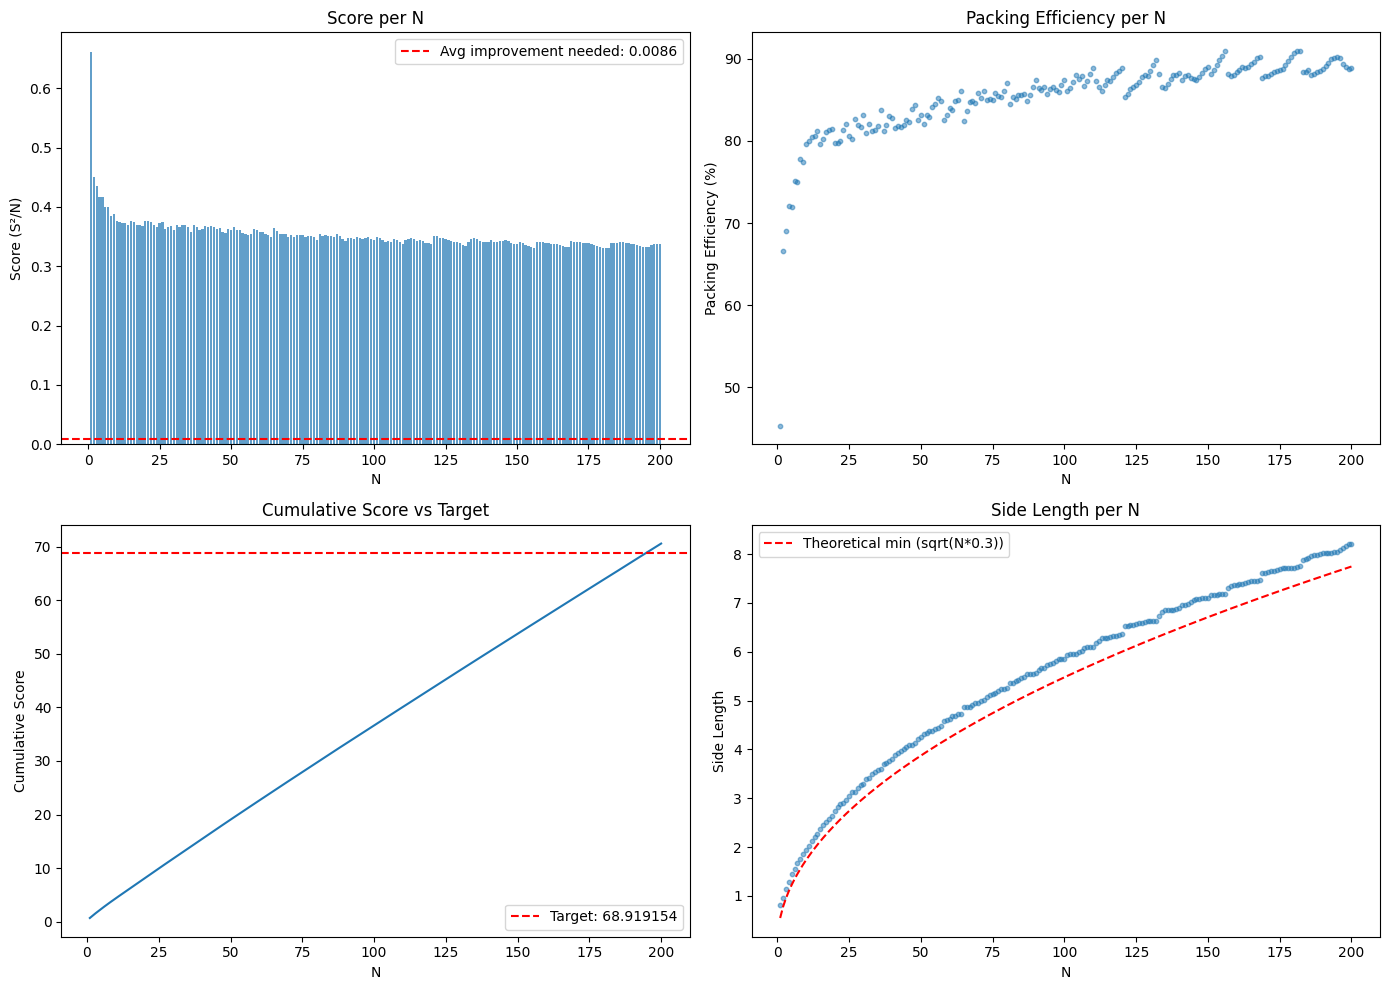


Plot saved to /home/code/exploration/loop12_score_analysis.png


In [6]:
# Visualize score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.bar(scores_df['n'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S²/N)')
ax1.set_title('Score per N')
ax1.axhline(y=gap/200, color='r', linestyle='--', label=f'Avg improvement needed: {gap/200:.4f}')
ax1.legend()

# Efficiency per N
ax2 = axes[0, 1]
ax2.scatter(scores_df['n'], scores_df['efficiency'], alpha=0.5, s=10)
ax2.set_xlabel('N')
ax2.set_ylabel('Packing Efficiency (%)')
ax2.set_title('Packing Efficiency per N')

# Cumulative score
ax3 = axes[1, 0]
scores_df['cumulative'] = scores_df['score'].cumsum()
ax3.plot(scores_df['n'], scores_df['cumulative'])
ax3.axhline(y=target, color='r', linestyle='--', label=f'Target: {target}')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score vs Target')
ax3.legend()

# Side length per N
ax4 = axes[1, 1]
ax4.scatter(scores_df['n'], scores_df['side'], alpha=0.5, s=10)
ax4.plot(scores_df['n'], np.sqrt(scores_df['n'] * 0.3), 'r--', label='Theoretical min (sqrt(N*0.3))')
ax4.set_xlabel('N')
ax4.set_ylabel('Side Length')
ax4.set_title('Side Length per N')
ax4.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/loop12_score_analysis.png', dpi=100)
plt.show()
print("\nPlot saved to /home/code/exploration/loop12_score_analysis.png")

In [7]:
# Key insight: What would it take to reach the target?
# Let's see if there are specific N values where we're far from optimal

print("=" * 60)
print("KEY INSIGHT: Where can we find 1.711 points of improvement?")
print("=" * 60)

# Option 1: Improve all N by 2.48%
print("\nOption 1: Uniform 2.48% improvement across all N")
print("  This requires finding better solutions for EVERY N value")
print("  Unlikely given that public solutions are already well-optimized")

# Option 2: Focus on low-efficiency N values
print("\nOption 2: Focus on N values with lowest efficiency")
low_eff = scores_df[scores_df['efficiency'] < 50]
print(f"  Found {len(low_eff)} N values with efficiency < 50%")
if len(low_eff) > 0:
    potential_improvement = low_eff['score'].sum() * 0.1  # 10% improvement on these
    print(f"  If we improve these by 10%: {potential_improvement:.4f} points")

# Option 3: Focus on small N (where SA works best)
print("\nOption 3: Focus on small N (1-20) where SA is most effective")
small_n_score = scores_df[scores_df['n'] <= 20]['score'].sum()
print(f"  Current small N score: {small_n_score:.4f}")
print(f"  If we improve by 10%: {small_n_score * 0.1:.4f} points")

# Option 4: Focus on large N (where crystalline packing helps)
print("\nOption 4: Focus on large N (100-200) where crystalline packing helps")
large_n_score = scores_df[scores_df['n'] >= 100]['score'].sum()
print(f"  Current large N score: {large_n_score:.4f}")
print(f"  If we improve by 5%: {large_n_score * 0.05:.4f} points")

print("\n" + "=" * 60)
print("CONCLUSION: The gap of 1.711 points is SIGNIFICANT")
print("We need fundamentally different solutions, not micro-optimizations")
print("=" * 60)

KEY INSIGHT: Where can we find 1.711 points of improvement?

Option 1: Uniform 2.48% improvement across all N
  This requires finding better solutions for EVERY N value
  Unlikely given that public solutions are already well-optimized

Option 2: Focus on N values with lowest efficiency
  Found 1 N values with efficiency < 50%
  If we improve these by 10%: 0.0661 points

Option 3: Focus on small N (1-20) where SA is most effective
  Current small N score: 8.0532
  If we improve by 10%: 0.8053 points

Option 4: Focus on large N (100-200) where crystalline packing helps
  Current large N score: 34.3228
  If we improve by 5%: 1.7161 points

CONCLUSION: The gap of 1.711 points is SIGNIFICANT
We need fundamentally different solutions, not micro-optimizations


In [8]:
# Let's look at the actual solutions for large N values to understand the structure
# Check what angles are being used for N=100, 150, 200

print("Analyzing solution structure for large N values:")
for n in [100, 150, 200]:
    group = df[df["id"].str.startswith(f"{n:03d}_")]
    angles = group["deg"].str.lstrip('s').astype(float)
    print(f"\nN={n}:")
    print(f"  Angle range: {angles.min():.2f}° to {angles.max():.2f}°")
    print(f"  Angle mean: {angles.mean():.2f}°")
    print(f"  Angle std: {angles.std():.2f}°")
    
    # Check if angles are clustered (indicating tessellation)
    angle_counts = angles.round(0).value_counts().head(5)
    print(f"  Top 5 angle clusters: {angle_counts.to_dict()}")

Analyzing solution structure for large N values:

N=100:
  Angle range: 65.74° to 249.70°
  Angle mean: 157.63°
  Angle std: 90.45°
  Top 5 angle clusters: {248.0: 22, 68.0: 22, 246.0: 14, 66.0: 13, 249.0: 6}

N=150:
  Angle range: 65.36° to 248.23°
  Angle mean: 154.51°
  Angle std: 90.21°
  Top 5 angle clusters: {68.0: 72, 248.0: 69, 67.0: 3, 247.0: 1, 246.0: 1}

N=200:
  Angle range: 76.81° to 293.63°
  Angle mean: 172.61°
  Angle std: 91.36°
  Top 5 angle clusters: {78.0: 47, 258.0: 47, 257.0: 46, 77.0: 45, 294.0: 5}
